In [3]:
#https://making.lyst.com/lightfm/docs/lightfm.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lightfm import LightFM

In [3]:
plays = pd.read_csv('data/lastfm/user_artists.dat', sep='\t')
artists = pd.read_csv('data/lastfm/artists.dat', sep='\t', usecols=['id','name'])

# Merge artist and user pref data
ap = pd.merge(artists, plays, how="inner", left_on="id", right_on="artistID")
ap = ap.rename(columns={"weight": "playCount"})

# Group artist by name
artist_rank = ap.groupby(['name']) \
    .agg({'userID' : 'count', 'playCount' : 'sum'}) \
    .rename(columns={"userID" : 'totalUsers', "playCount" : "totalPlays"}) \
    .sort_values(['totalPlays'], ascending=False)

artist_rank['avgPlays'] = artist_rank['totalPlays'] / artist_rank['totalUsers']
print(artist_rank)


                    totalUsers  totalPlays     avgPlays
name                                                   
Britney Spears             522     2393140  4584.559387
Depeche Mode               282     1301308  4614.567376
Lady Gaga                  611     1291387  2113.563011
Christina Aguilera         407     1058405  2600.503686
Paramore                   399      963449  2414.659148
...                        ...         ...          ...
Morris                       1           1     1.000000
Eddie Kendricks              1           1     1.000000
Excess Pressure              1           1     1.000000
My Mine                      1           1     1.000000
A.M. Architect               1           1     1.000000

[17632 rows x 3 columns]


In [4]:
artist_name = ap['name'].unique()
artist_name

array(['MALICE MIZER', 'Diary of Dreams', 'Carpathian Forest', ...,
       'Coptic Rain', 'Oz Alchemist', 'Grzegorz Tomczak'], dtype=object)

DATA Statistics :  
   1892 users
   17632 artists
      
   12717 bi-directional user friend relations, i.e. 25434 (user_i, user_j) pairs
         avg. 13.443 friend relations per user
         
   92834 user-listened artist relations, i.e. tuples [user, artist, listeningCount]
         avg. 49.067 artists most listened by each user
         avg. 5.265 users who listened each artist
            
   11946 tags  
   
  186479 tag assignments (tas), i.e. tuples [user, tag, artist]
         avg. 98.562 tas per user
         avg. 14.891 tas per artist
         avg. 18.930 distinct tags used by each user
         avg. 8.764 distinct tags used for each artist	    
   
* artists.dat
   
        This file contains information about music artists listened and tagged by the users.
   
   * tags.dat
   
   	This file contains the set of tags available in the dataset.

   * user_artists.dat
   
        This file contains the artists listened by each user.
        
        It also provides a listening count for each [user, artist] pair.

   * user_taggedartists.dat - user_taggedartists-timestamps.dat
   
        These files contain the tag assignments of artists provided by each particular user.
        
        They also contain the timestamps when the tag assignments were done.
   
   * user_friends.dat
   
   	These files contain the friend relations between users in the database.

In [5]:
# Merge into ap matrix
ap = ap.join(artist_rank, on="name", how="inner") \
    .sort_values(['playCount'], ascending=False)

# Preprocessing
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
ap = ap.assign(playCountScaled=play_count_scaled)
#print(ap)

# Build a user-artist rating matrix 
ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
ratings = ratings_df.fillna(0).values

# Show sparsity
sparsity = float(len(ratings.nonzero()[0])) / (ratings.shape[0] * ratings.shape[1]) * 100
print("sparsity: %.2f" % sparsity)
#print(ap.il)

sparsity: 0.28


In [6]:
ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00115397, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
#ap["name"][ap["artistID"] ==72]

In [7]:
from scipy.sparse import csr_matrix

# Build a sparse matrix
X = csr_matrix(ratings)

n_users, n_items = ratings_df.shape
print("rating matrix shape", ratings_df.shape)

user_ids = ratings_df.index.values
artist_names = ap.sort_values("artistID")["name"].unique()

rating matrix shape (1892, 17632)


In [8]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, # Build data references + train test
Xcoo = X.tocoo()
data = Dataset()
data.fit(np.arange(n_users), np.arange(n_items))
interactions, weights = data.build_interactions(zip(Xcoo.row, Xcoo.col, Xcoo.data)) 
train, test = random_train_test_split(interactions)precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset



# Ignore that (weight seems to be ignored...)
#train = train_.tocsr()
#test = test_.tocsr()
#train[train==1] = X[train==1]
#test[test==1] = X[test==1]

# To be completed...


In [9]:
print(" train shape :", train.shape)
print(" test shape :", test.shape)

 train shape : (1892, 17632)
 test shape : (1892, 17632)


In [10]:
def learning (loss, train, test): 
    # Train
    model = LightFM(learning_rate=0.05, loss=loss)
    model.fit(train, epochs=10, num_threads=2)
    
    # Evaluate
    train_precision = precision_at_k(model, train, k=10).mean()
    test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

    train_auc = auc_score(model, train).mean()
    test_auc = auc_score(model, test, train_interactions=train).mean()

    #print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    #print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))
    return train_precision , test_precision , train_auc, test_auc

train_precision = [] 
test_precision = [] 
train_auc = []
test_auc =  []


LOSS = ['warp','bpr','logistic','warp-kos']

for l in LOSS :
    
    tr , ts, auc_tr, auc_ts = learning(l,train, test )
   
    train_precision.append(round(tr,3)) 
    test_precision.append(round(ts,3)) 
    train_auc.append(round(auc_tr,3))
    test_auc.append(round(auc_ts,3))
    
    
#mettre les résultats d'un dictionnaire et le convertir ds un dataframe
dict_result = {}
dict_result ['Loss'] = LOSS
dict_result ['Train_precision'] = train_precision
dict_result ['Test_precision'] = test_precision
dict_result ['Train_auc'] = train_auc
dict_result ['test_auc'] = test_auc 

df = pd.DataFrame.from_dict(dict_result)
df

,Loss,Train_precision,Test_precision,Train_auc,test_auc
0,warp,0.366,0.129,0.963,0.856
1,bpr,0.336,0.115,0.835,0.772
2,logistic,0.196,0.069,0.888,0.806
3,warp-kos,0.344,0.123,0.889,0.818


### Part 1
faire la fonction get_recommandation qui prend en entrée un User et renvoie les Artists recommandé (du meilleurs au moins bon au sens du score de recommandation)

In [94]:
ap.head(4)

,id,name,userID,artistID,playCount,totalUsers,totalPlays,avgPlays,playCountScaled
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376,1.000000
35843,792,Thalía,2071,792,324663,26,350035,13462.884615,0.920513
27302,511,U2,1094,511,320725,185,493024,2664.994595,0.909347
8152,203,Blur,1905,203,257978,114,318221,2791.412281,0.731441


In [76]:
ap["name"][ap["artistID"] ==72]

2800    Depeche Mode
2635    Depeche Mode
2829    Depeche Mode
2852    Depeche Mode
2689    Depeche Mode
            ...     
2578    Depeche Mode
2717    Depeche Mode
2694    Depeche Mode
2722    Depeche Mode
2771    Depeche Mode
Name: name, Length: 282, dtype: object

In [45]:
#ap["name"][ap["artistID"] ==72]

index = ap["name"][ap["userID"] ==1642]
#index

In [11]:
#Convergeances : 
#from sklearn.metrics import precision_score, recall_score

epochs = 100

model = LightFM(learning_rate=0.05, loss='warp')

#model.fit(train, epochs=10, num_threads=2)

auc =[]

for epoch in range(epochs):
    model.fit_partial(train, epochs=1)
    auc.append(auc_score(model, test).mean())
   

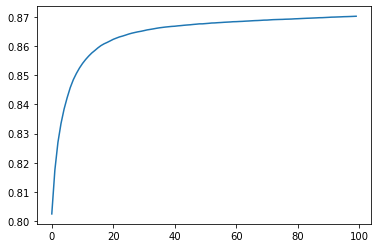

In [23]:

x = np.arange(len(auc))
plt.plot(x, np.array(auc))

plt.show()


In [ ]:
Le modèle commence à converger à partir de 20 itérations.

In [12]:
# définitiondu model
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(train, epochs=10, num_threads=2)

faire la fonction get_recommandation qui prend en entrée un User et renvoie les Artists recommandé (du meilleurs au moins bon au sens du score de recommandation)

In [13]:

def get_recommendation(model, data, user_id):


        n_users, n_items = data.shape
        scores = model.predict(user_id, np.arange(n_items))
        top_items = artist_names[np.argsort(-scores)]
        print("User %s" % user_id)
        print("     Recommended:")

        for x in top_items[:6]:
            print("        %s" % x)



In [14]:

get_recommendation(model, ratings, 162)

User 162
     Recommended:
        The Beatles
        Coldplay
        The Killers
        Muse
        Depeche Mode
        Arctic Monkeys


In [15]:
# SVD iterration à 15 , composants = 100, title =  GoldenEye
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
matrix_reduit= svd.fit_transform(X)
matrix_reduit.shape

(1892, 100)

In [16]:
# prédition avec la SVD à explorer
pred=matrix_reduit[0].dot(svd.components_[:,0])
#svd.components_[:,0]
pred

6.4748161881419704e-06

In [17]:
from pprint import pprint

# Look at parameters used by our model
print('Les parametres utilisés:\n')
pprint(model.get_params())

Les parametres utilisés:

{'epsilon': 1e-06,
 'item_alpha': 0.0,
 'k': 5,
 'learning_rate': 0.05,
 'learning_schedule': 'adagrad',
 'loss': 'warp',
 'max_sampled': 10,
 'n': 10,
 'no_components': 10,
 'random_state': RandomState(MT19937) at 0x7F3DDF485AF0,
 'rho': 0.95,
 'user_alpha': 0.0}


In [18]:

# Optimisation de paramètres avec GridSearch, en selectionnant les paramètres sur lesquels intervenir

from sklearn.model_selection import ParameterGrid# Create the parameter grid based on the results of random search 

param_grid = {
    'learning_rate': [0.05 , 0.08],
    'learning_schedule':['adagrad','adadelta'],
    'loss': ['warp','bpr','logistic','warp-kos']
    
}
# definition liste score auc
auc_score_values = []

for grid in ParameterGrid(param_grid):
    model = LightFM(**grid)
    pred = model.fit(train)
    auc_score_values.append(round(auc_score(model, test, train_interactions=train).mean(),3))
    
max_value = max(auc_score_values) 
max_index = np.argmax(auc_score_values)
ParameterGrid(param_grid)[max_index ].items()


dict_items([('loss', 'warp'), ('learning_schedule', 'adadelta'), ('learning_rate', 0.08)])

In [19]:
print(f"la combinaison de paramètres qui permet d'optimiser le modèle : {round(max_value,3)} est la suivante \n {ParameterGrid(param_grid)[max_index ].items()}") 

la combinaison de paramètres qui permet d'optimiser le modèle : 0.8159999847412109 est la suivante 
 dict_items([('loss', 'warp'), ('learning_schedule', 'adadelta'), ('learning_rate', 0.08)])


#### Application flask Client _serveur


Etape1 : coté interfance utilisateur :
1. charger le train et le test : ok
2. afficher la liste des artistes : 50
3. recupèrer le choix de l'utilisateur

Etape2 : Coté appli

1. définir le model avec les parametres optimisés : def leraning ===> ok 
2. mettre le choix de l'utilisateur lors de l'étape (1.3) sous forme acceptable par la fonction get_recommandation 
créer un vecteur avec le choix de l'utilisateur, le rajouter au début de la matrice  et obtenir l'index
3. appeler la fonction get_recommandation le resultat de l'étape suivante et obtenir le résultat l'étape (2.3)

Etape 3: Coté interface utilisateur :
1. afficher le résultat obtenu lors de l'étape précedente.
2 proposer une nouvelle recherche.




In [70]:
#B = vstack([x,[[1.  , 1.  , 1.  , 1.  , 0.2 ]]])